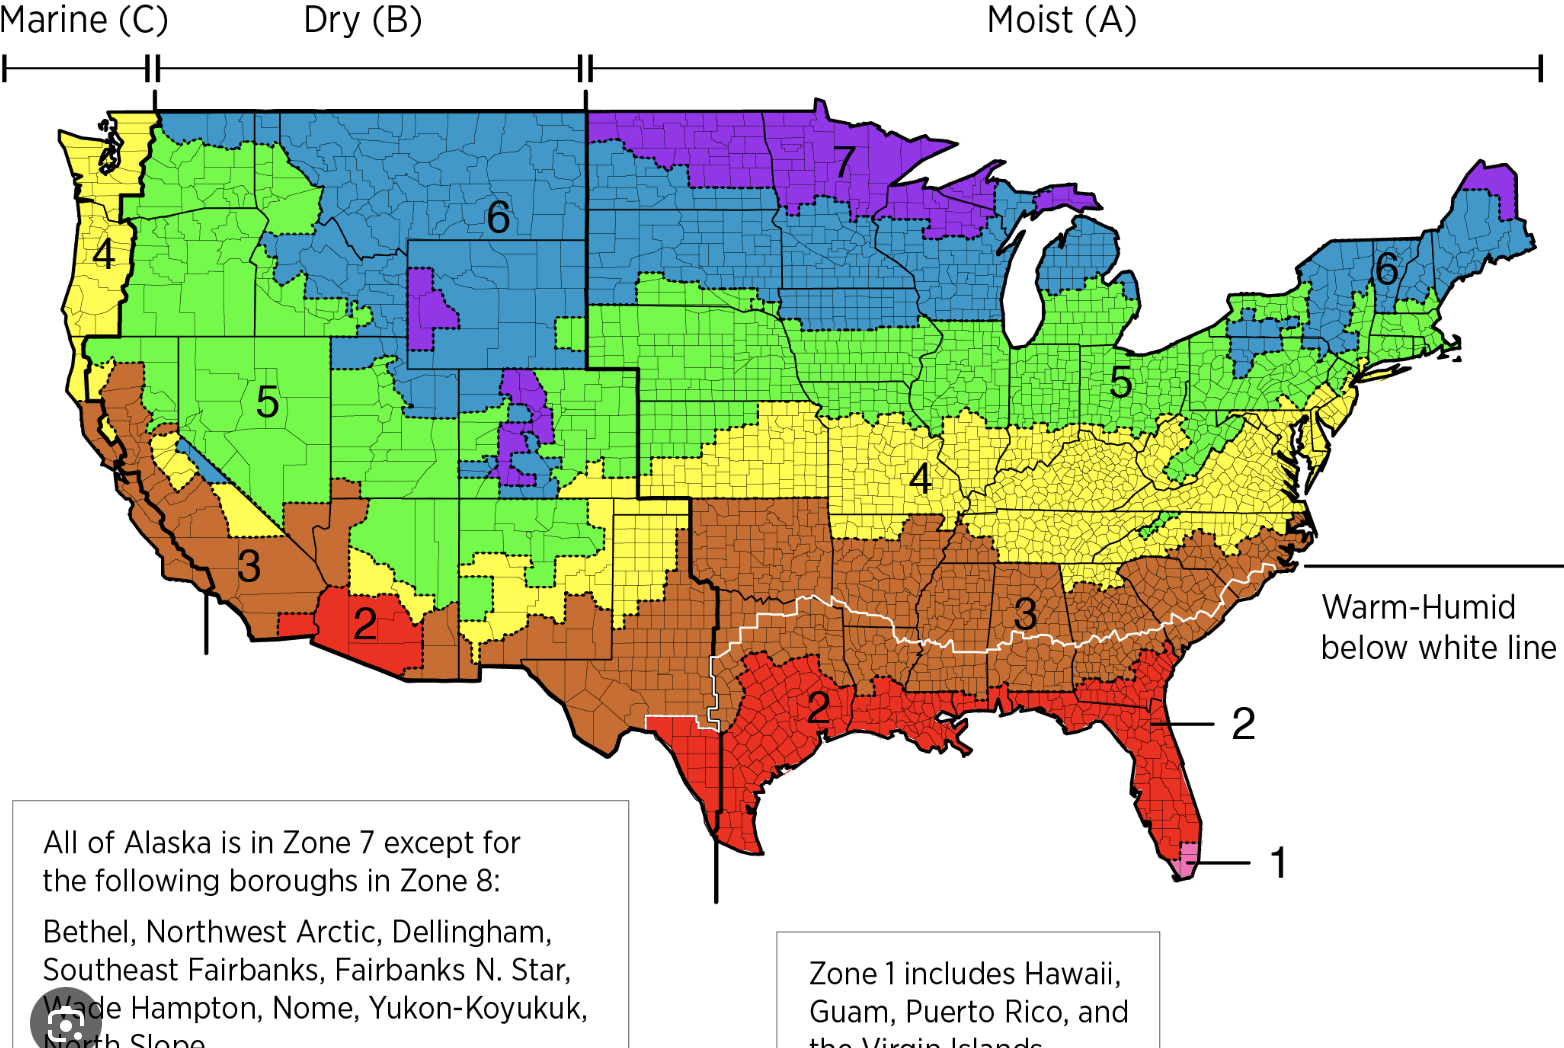

In [1]:

from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

from datasets.cbecs.lookups import lookup_pba

dataset_path = Path().resolve() / "datasets"
# get the full path
print(f"Dataset path: {dataset_path}")

data_path = dataset_path / "comstock"
# get the full path
print(f"Data path: {data_path}")

# auto reload any changes in the module
%load_ext autoreload

{1: 'Vacant', 2: 'Office', 4: 'Laboratory', 5: 'Nonrefrigerated warehouse', 6: 'Food sales', 7: 'Public order and safety', 8: 'Outpatient health care', 11: 'Refrigerated warehouse', 12: 'Religious worship', 13: 'Public assembly', 14: 'Education', 15: 'Food service', 16: 'Inpatient health care', 17: 'Nursing', 18: 'Lodging', 23: 'Strip shopping center', 24: 'Enclosed mall', 25: 'Retail other than mall', 26: 'Service', 91: 'Other'}
Dataset path: C:\NREL\compare-building-data\datasets
Data path: C:\NREL\compare-building-data\datasets\comstock


# ComStock

### Pull down ComStock data

To do this, you should be able to just simply run the `comstock_processor.py` file within VSCode. The data will be saved into 
the ComStock subfolder. It takes a while to run (10ish minutes).

In [2]:
# %run comstock_processor.py

### Read in ComStock data

In [3]:
# read in the comstock exported file, yes we could just read the parquet, maybe update?
df_all = pd.read_csv(data_path / 'All-All-All-0-selected_metadata.csv')

C:\Users\lkerr\AppData\Local\Temp\1\ipykernel_7680\2600952076.py:2: DtypeWarning: Columns (15,57,578,585,850) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(data_path / 'All-All-All-0-selected_metadata.csv')


In [4]:
# get the dimensions
print(df_all.shape)
# show all states
print(df_all['in.state'].unique())
# show all the building types
print(df_all['in.comstock_building_type'].unique())

(346185, 1056)
['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']
['Outpatient' 'Hospital' 'LargeOffice' 'LargeHotel' 'SmallOffice'
 'RetailStandalone' 'Warehouse' 'SecondarySchool' 'RetailStripmall'
 'SmallHotel' 'PrimarySchool' 'QuickServiceRestaurant' 'MediumOffice'
 'FullServiceRestaurant']


In [5]:
# save the names of the fields to a list
fields = df_all.columns
open(data_path / 'fields.txt', 'w').write('\n'.join(fields))

# force the climate zone to be a string
df_all['in.ashrae_iecc_climate_zone_2006'] = df_all['in.ashrae_iecc_climate_zone_2006'].astype(str)
# print the unique values
print(df_all['in.ashrae_iecc_climate_zone_2006'].unique())


['3A' '2A' '7' '8' '2B' '3B' '4B' '4A' '3C' '5B' '6B' '5A' '1A' '6A' '7A'
 '4C' '7B']


In [6]:
# find if climate zone 7A or 7B or 7
df_cz7 = df_all[df_all['in.ashrae_iecc_climate_zone_2006'].str.contains('7')]
print(df_cz7['in.state'].unique())
df_co_cz7 = df_cz7[df_cz7['in.state'] == 'CO']
df_pitkin = df_all[df_all['in.county_name'] == 'CO, Pitkin County']

# print the dimensions for each dataframe
print(f"all: {df_all.shape}")
print(f"cz7: {df_cz7.shape}")
print(f"cz7 co: {df_co_cz7.shape}")
print(f"cz7 pitkin: {df_pitkin.shape}")


['AK' 'MN' 'ND' 'WI' 'CO' 'ME' 'MI' 'WY']
all: (346185, 1056)
cz7: (2491, 1056)
cz7 co: (193, 1056)
cz7 pitkin: (25, 1056)


In [7]:
display(df_cz7)
display(df_pitkin)

# # list all the columns that have "weighted" and "intensity" in the name
# weighted_cols = [col for col in df_all.columns if 'weighted' in col]
# print(weighted_cols)



,bldg_id,metadata_index,upgrade,weight,in.sqft,calc.weighted.sqft,in.upgrade_name,applicability,in.building_america_climate_zone,in.cambium_grid_region,...,calc.weighted.savings.natural_gas.interior_equipment.energy_consumption..tbtu,calc.weighted.savings.natural_gas.total.energy_consumption..tbtu,calc.weighted.savings.natural_gas.water_systems.energy_consumption..tbtu,calc.weighted.savings.other_fuel.cooling.energy_consumption..tbtu,calc.weighted.savings.other_fuel.heating.energy_consumption..tbtu,calc.weighted.savings.other_fuel.interior_equipment.energy_consumption..tbtu,calc.weighted.savings.other_fuel.total.energy_consumption..tbtu,calc.weighted.savings.other_fuel.water_systems.energy_consumption..tbtu,calc.weighted.savings.site_energy.total.energy_consumption..tbtu,calc.weighted.site_energy.total.energy_consumption..tbtu
40,5338,40,0,7.402800,150000.0,1.110420e+06,Baseline,True,Very Cold,AKMS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148871
42,5508,42,0,4.088175,37500.0,1.533066e+05,Baseline,True,Very Cold,AKGD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014962
43,5519,43,0,7.402800,150000.0,1.110420e+06,Baseline,True,Very Cold,AKGD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171448
1455,170976,1455,0,7.402800,350000.0,2.590980e+06,Baseline,True,Very Cold,MROWc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.356607
1459,171840,1459,0,4.088175,17500.0,7.154306e+04,Baseline,True,Very Cold,MROWc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346069,349885,346069,0,3.204584,7500.0,2.403438e+04,Baseline,True,Very Cold,NWPPc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003332
346105,349921,346105,0,9.729435,75000.0,7.297076e+05,Baseline,True,Very Cold,NWPPc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060513
346163,349979,346163,0,1.870652,3000.0,5.611956e+03,Baseline,True,Very Cold,NWPPc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000865
346164,349980,346164,0,7.566858,7500.0,5.675143e+04,Baseline,True,Very Cold,NWPPc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029682


,bldg_id,metadata_index,upgrade,weight,in.sqft,calc.weighted.sqft,in.upgrade_name,applicability,in.building_america_climate_zone,in.cambium_grid_region,...,calc.weighted.savings.natural_gas.interior_equipment.energy_consumption..tbtu,calc.weighted.savings.natural_gas.total.energy_consumption..tbtu,calc.weighted.savings.natural_gas.water_systems.energy_consumption..tbtu,calc.weighted.savings.other_fuel.cooling.energy_consumption..tbtu,calc.weighted.savings.other_fuel.heating.energy_consumption..tbtu,calc.weighted.savings.other_fuel.interior_equipment.energy_consumption..tbtu,calc.weighted.savings.other_fuel.total.energy_consumption..tbtu,calc.weighted.savings.other_fuel.water_systems.energy_consumption..tbtu,calc.weighted.savings.site_energy.total.energy_consumption..tbtu,calc.weighted.site_energy.total.energy_consumption..tbtu
57301,56468,57301,0,1.870652,17500.0,3.273641e+04,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004205
57388,56555,57388,0,9.525004,17500.0,1.666876e+05,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025011
57870,57044,57870,0,7.566858,17500.0,1.324200e+05,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049020
57990,57169,57990,0,1.870652,37500.0,7.014946e+04,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007521
58003,57183,58003,0,1.870652,7500.0,1.402989e+04,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001905
58260,57447,58260,0,7.614024,75000.0,5.710518e+05,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043848
58310,57497,58310,0,5.759960,17500.0,1.007993e+05,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006649
58372,57559,58372,0,7.566858,3000.0,2.270057e+04,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008957
58691,57887,58691,0,9.525004,150000.0,1.428751e+06,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136682
58906,58107,58906,0,7.402800,75000.0,5.552100e+05,Baseline,True,Very Cold,RMPAc,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057378


count    2491.000000
mean       48.939364
std        42.778277
min         7.074741
25%        24.391746
50%        36.147519
75%        54.247288
max       441.866667
Name: out.site_energy.total.energy_consumption_intensity, dtype: float64


C:\Users\lkerr\AppData\Local\Temp\1\ipykernel_7680\2753590148.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_cz7['out.site_energy.total.energy_consumption_intensity'], shade=True)
C:\Users\lkerr\AppData\Local\Temp\1\ipykernel_7680\2753590148.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pitkin['out.site_energy.total.energy_consumption_intensity'], shade=True)


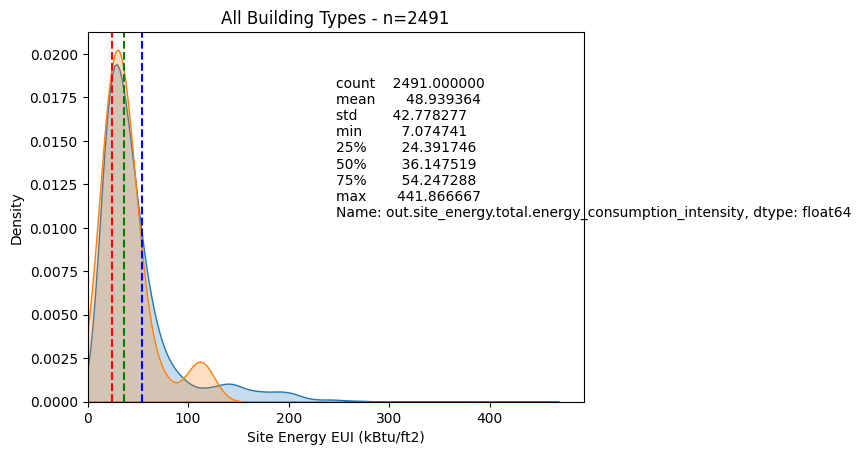

In [8]:

# use seaborn

# return the quartiles of the column out.site_energy.total.energy_consumption_intensity
print(df_cz7['out.site_energy.total.energy_consumption_intensity'].describe())

# create kernel density plot of the column out.site_energy.total.energy_consumption_intensity, using seaborn
sns.kdeplot(df_cz7['out.site_energy.total.energy_consumption_intensity'], shade=True)
# add dashed lines for the quartiles
describe_data = df_cz7['out.site_energy.total.energy_consumption_intensity'].describe()
plt.axvline(describe_data['25%'], color='r', linestyle='--')
plt.axvline(describe_data['50%'], color='g', linestyle='--')
plt.axvline(describe_data['75%'], color='b', linestyle='--')
plt.xlabel('Site Energy EUI (kBtu/ft2)')
plt.title(f'All Building Types - n={len(df_cz7)}')
# display the quartiles in a text box
plt.text(0.5, 0.5, describe_data, transform=plt.gca().transAxes)
plt.xlim(0)

# add in the df_piitkin data
sns.kdeplot(df_pitkin['out.site_energy.total.energy_consumption_intensity'], shade=True)
plt.show()


{0.0: 11.111333333333334,
 0.25: 21.117658730158723,
 0.5: 27.16762962962963,
 0.75: 36.15100529100529,
 1.0: 319.4814814814815}

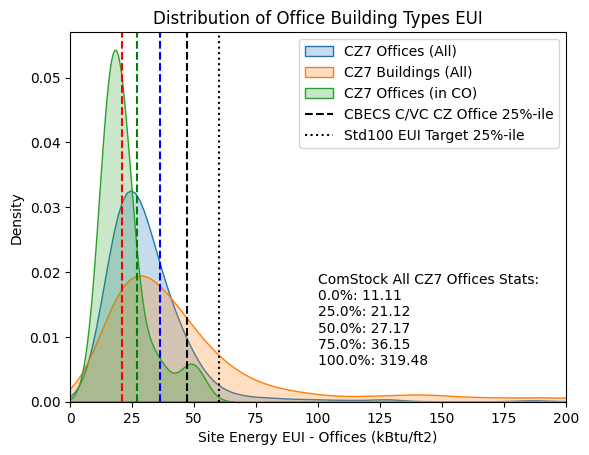

In [9]:
# create KDE's for only "SmallOffice", "MediumOffice", "LargeOffice"   
df_cz7_office = df_cz7[df_cz7['in.comstock_building_type'].isin(["SmallOffice", "MediumOffice", "LargeOffice"])]
df_cz7_co_office = df_co_cz7[df_co_cz7['in.comstock_building_type'].isin(["SmallOffice", "MediumOffice", "LargeOffice"])]

# create kernel density plot of the column out.site_energy.total.energy_consumption_intensity, using seaborn
sns.kdeplot(df_cz7_office['out.site_energy.total.energy_consumption_intensity'], fill=True, legend=True)
# add in the df_piitkin data
sns.kdeplot(df_cz7['out.site_energy.total.energy_consumption_intensity'], fill=True, legend=True)
sns.kdeplot(df_cz7_co_office['out.site_energy.total.energy_consumption_intensity'], fill=True, legend=True)
# add dashed lines for the quartiles
describe_data = df_cz7_office['out.site_energy.total.energy_consumption_intensity'].quantile([0, 0.25, 0.5, 0.75, 1.0])
describe_data = describe_data.to_dict()
display(describe_data)
# show only describe from the column out.site_energy.total.energy_consumption_intensity

# add line at 47.2 called CBECS C/VC CZ Office
plt.axvline(47.2, color='k', linestyle='--', label='CBECS C/VC CZ Office')
plt.axvline(60, color='k', linestyle=':', label='ASHRAE Std 100')

plt.axvline(describe_data[0.25], color='r', linestyle='--')
plt.axvline(describe_data[0.5], color='g', linestyle='--')
plt.axvline(describe_data[0.75], color='b', linestyle='--')
plt.xlabel('Site Energy EUI - Offices (kBtu/ft2)')
plt.title(f'Distribution of Office Building Types EUI')


# display the quartiles in a text box
textstr = 'ComStock All CZ7 Offices Stats:\n' + '\n'.join([f'{k*100}%: {v:.2f}' for k, v in describe_data.items()])

plt.text(0.5, 0.1, textstr, transform=plt.gca().transAxes)
plt.xlim(0, 200)

# add legend
plt.legend(['CZ7 Offices (All)', 'CZ7 Buildings (All)', 'CZ7 Offices (in CO)', 'CBECS C/VC CZ Office 25%-ile', 'Std100 EUI Target 25%-ile'])

plt.show()



# CBECS



In [10]:
# read in the xlsx spreadsheet sheet called cbecs2018_final_public

cbecs2018 = pd.read_excel(dataset_path / "cbecs" / "cbecs2018_final_public.xlsx", sheet_name="cbecs2018_final_public")


In [11]:
display(cbecs2018)

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
0,1,3,5,2,3,210000,8,1,4,2,...,0,0,0,0,9,9,1,1,0,0
1,2,4,9,2,4,28000,5,1,6,1,...,0,0,0,0,0,0,9,9,9,9
2,3,3,5,8,4,2100,2,1,4,2,...,0,0,0,0,9,9,9,9,9,9
3,4,3,7,5,5,240000,8,2,6,1,...,0,0,0,0,1,1,9,9,9,9
4,5,1,2,5,3,295000,8,3,6,2,...,0,0,0,0,0,0,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,6432,4,8,14,2,130000,7,1,1,2,...,0,0,0,0,0,0,9,9,9,9
6432,6433,3,7,1,4,1050,2,1,5,2,...,9,9,9,9,9,9,9,9,9,9
6433,6434,3,5,2,4,122000,7,2,6,1,...,1,1,1,1,9,9,9,9,9,9
6434,6435,3,5,23,4,15000,4,3,5,1,...,2,2,2,2,2,2,9,9,9,9


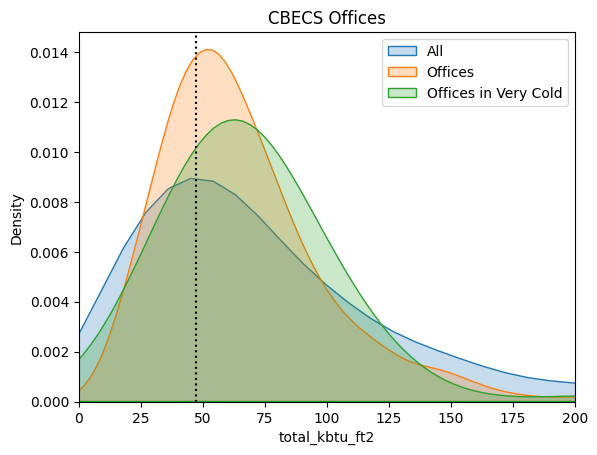

In [12]:
# calculate the total kbtu/ft2 for each building
cbecs2018["total_kbtu_ft2"] = cbecs2018["MFBTU"] / cbecs2018["SQFT"]


# create the kde plot of all kbtu/ft2 
sns.kdeplot(cbecs2018["total_kbtu_ft2"], fill=True)

# filter only offices
offices = cbecs2018[cbecs2018["PBA"] == 2]
sns.kdeplot(offices["total_kbtu_ft2"], fill=True)

# only offices in very cold
offices_very_cold = offices[offices["PUBCLIM"] == 1]
sns.kdeplot(offices_very_cold["total_kbtu_ft2"], fill=True)
# add legend
plt.legend(["All", "Offices", "Offices in Very Cold"])
plt.xlim(0,200)
plt.title("CBECS Offices")


# 1st quartile of the offices_very_cold
offices_very_cold_1st_quartile = offices_very_cold["total_kbtu_ft2"].quantile(0.25)
# plot as line
plt.axvline(offices_very_cold_1st_quartile, color="black", linestyle=":")


# ESPM Colorado Site EUI
https://portfoliomanager.energystar.gov/dataExplorer/?_gl=1*1cjut0r*_ga*NzE4OTQ5MDM4LjE3MjM1ODY2NzY.*_ga_S0KJTVVLQ6*MTcyMzU4NjY3Ni4xLjAuMTcyMzU4NjY3Ni4wLjAuMA..

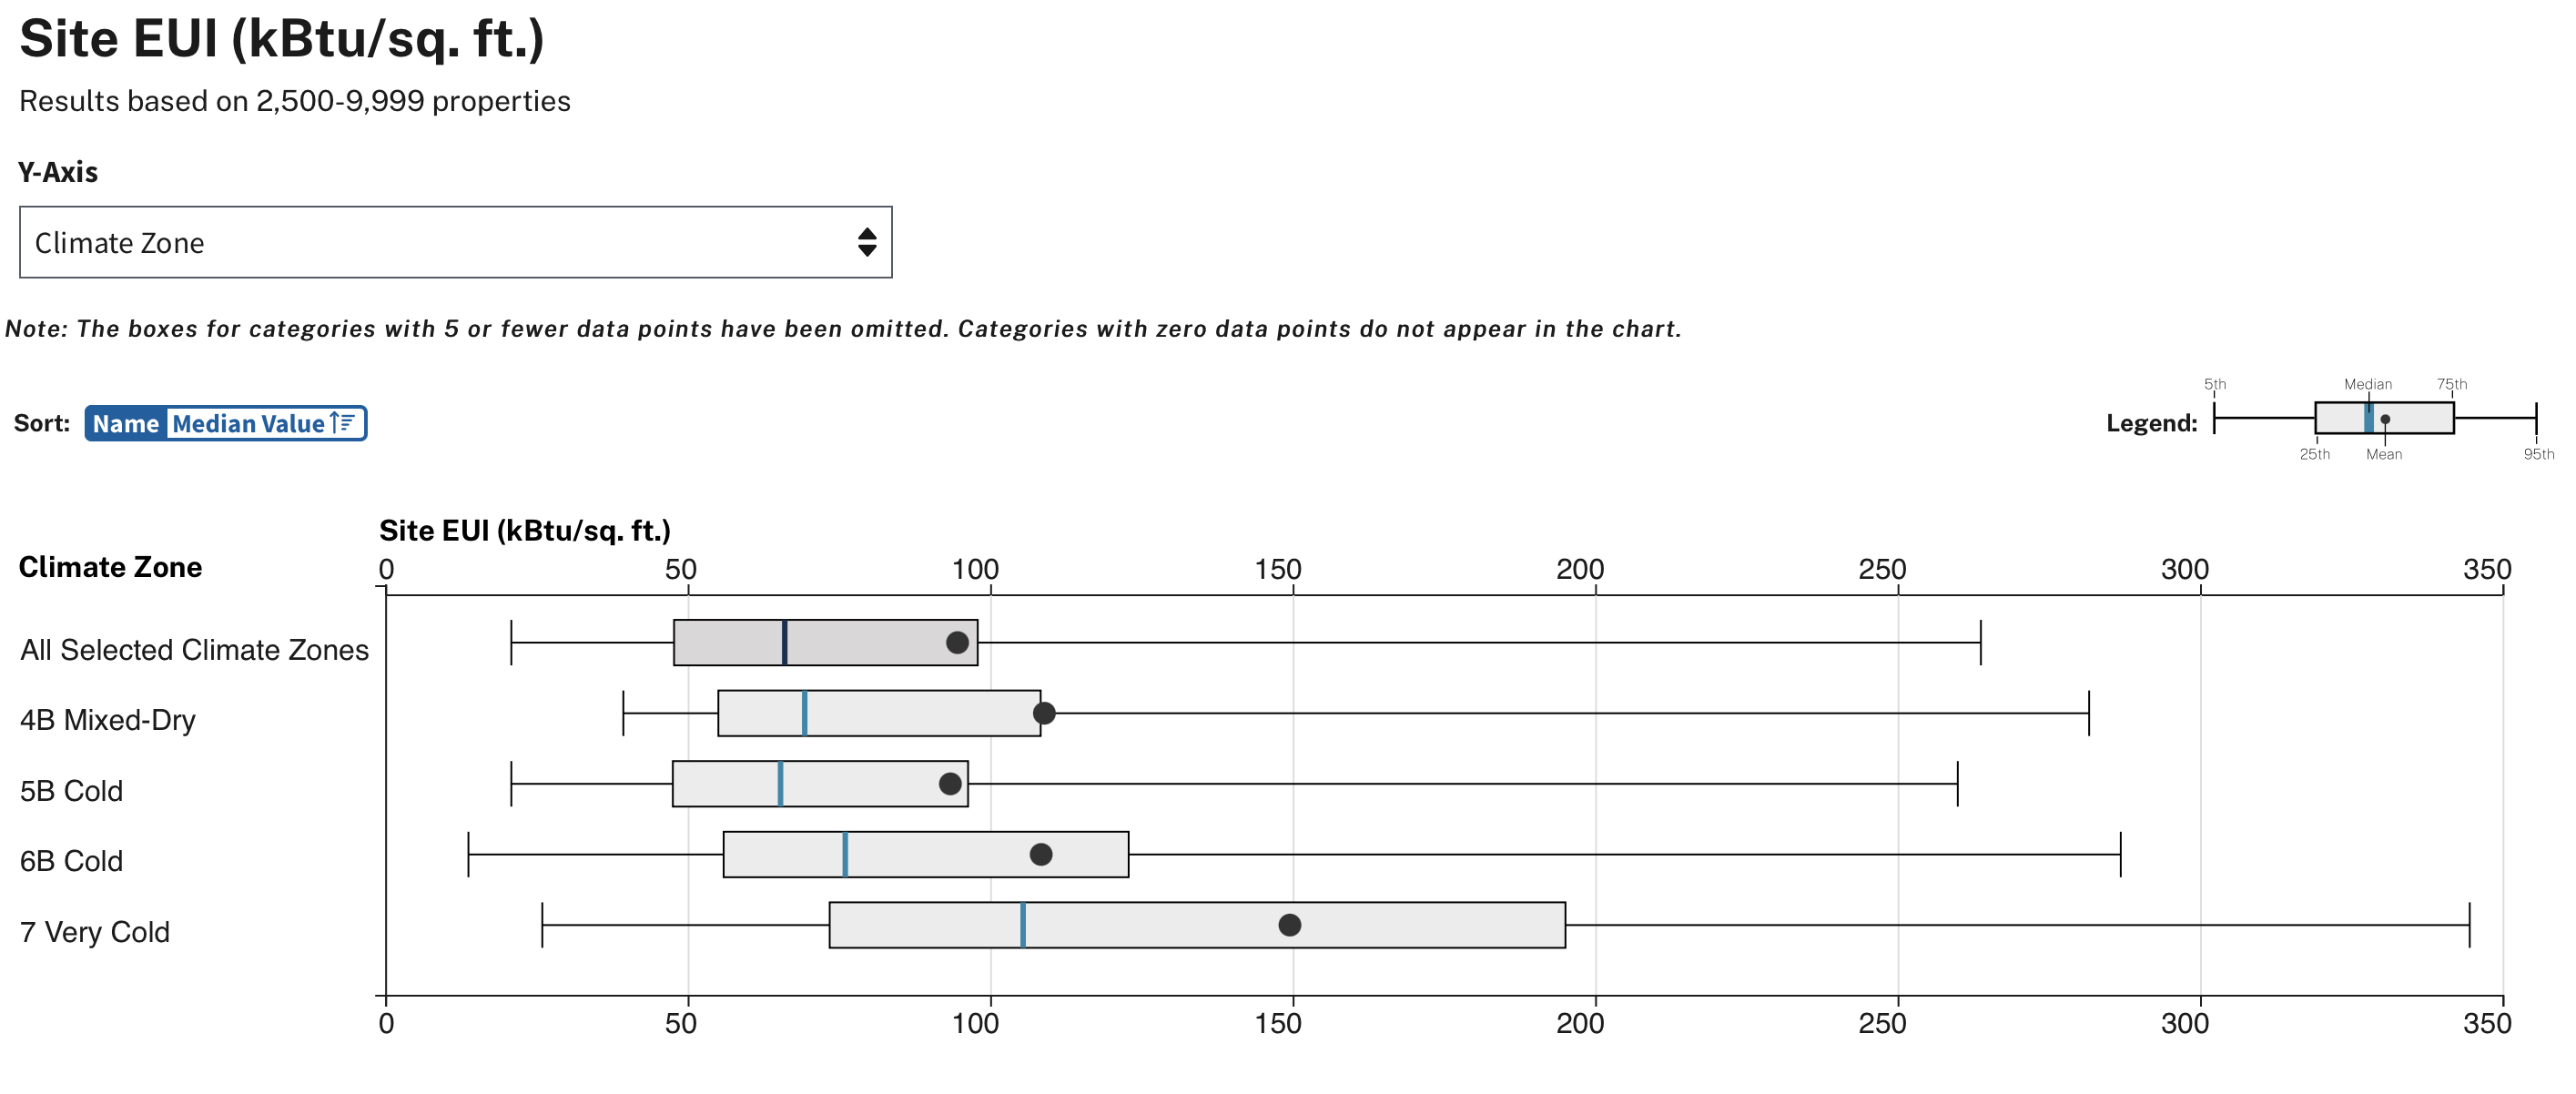{ width=50% }


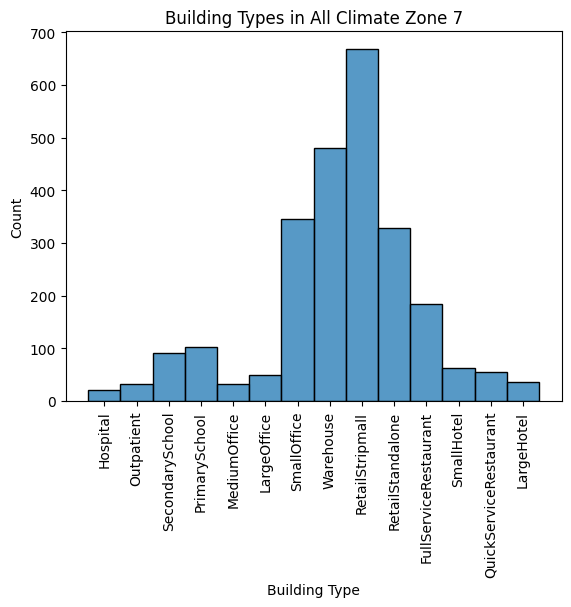

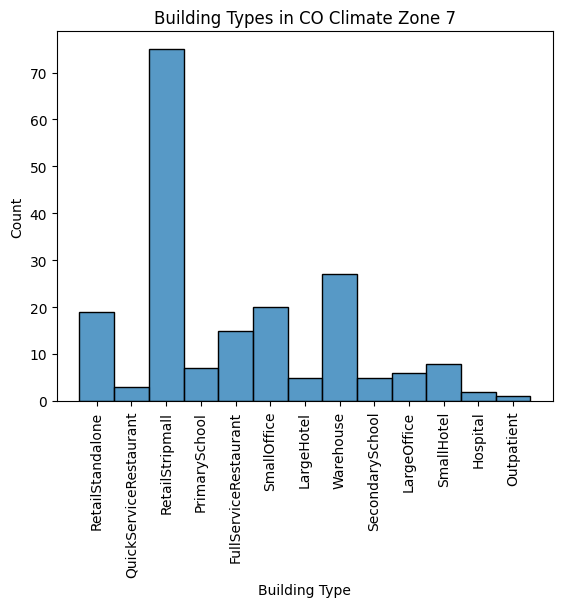

In [13]:
# show histogram of the building types - in.comstock_building_type

# It would be nice to have this image for each of the data sources
sns.histplot(df_cz7['in.comstock_building_type'])
plt.xlabel('Building Type')
plt.title('Building Types in All Climate Zone 7')
plt.xticks(rotation=90)
plt.show()

# show histogram of the building types - in.comstock_building_type
sns.histplot(df_co_cz7['in.comstock_building_type'])
plt.xlabel('Building Type')
plt.title('Building Types in CO Climate Zone 7')
plt.xticks(rotation=90)
plt.show()


# Data Comparison

In [14]:
# Read in std data
std100_25thPercentile = pd.read_excel(dataset_path / "std100" / "std100data_percentiles_allclimatezones_allbuildingtypes.xlsx", sheet_name="25thPercentile")
std100_40thPercentile = pd.read_excel(dataset_path / "std100" / "std100data_percentiles_allclimatezones_allbuildingtypes.xlsx", sheet_name="40thPercentile")
std100_50thPercentile = pd.read_excel(dataset_path / "std100" / "std100data_percentiles_allclimatezones_allbuildingtypes.xlsx", sheet_name="50thPercentile")

# display(std25thPercentile)

#Read in ESPM data
espm_data = pd.read_excel(dataset_path / "espm" / "ESPM_allBuildingTypes_AllClimateZones.xlsx", sheet_name="Report")

# display(espm_data)


# Comparison boxplot of all Zone 7 building types

C:\Users\lkerr\AppData\Local\Temp\1\ipykernel_7680\2987272933.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comstock_cz7["data_source"] = "COMSTOCK"


(0.0, 250.0)

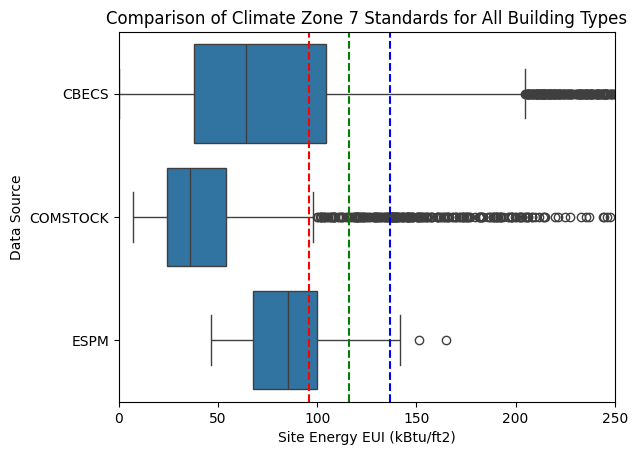

In [15]:
# CBECS Data Handling: 
#   calculate the total kbtu/ft2 for each building
#   add in literal column for data_source for union and display in visualization
#   Filter just to climate zone "Cold or Very Cold" (See lookups.py in the cbecs data folder for additional definitions for different numbers, not the same as climate zone numbers)
#   Select data needed for union and visualization
#   Note if needed: PBA is building type
cbecs2018["EUI _kBTUft2"] = cbecs2018["MFBTU"] / cbecs2018["SQFT"]
cbecs2018["data_source"] = "CBECS"
cbecs2018["PUBCLIM"] = 1
cbecs2018ForComparison = cbecs2018[["data_source","EUI _kBTUft2"]]

# Comstock Data Handling:
#   Filter just to climate zone 7 (very cold)
#   add in literal column for data_source for union and display in visualization
#   Select data needed for union and visualization
#   Rename columns for union
#   Note if needed: in.comstock_building_type is building type for comstock data; 
comstock_cz7 = df_all[df_all['in.ashrae_iecc_climate_zone_2006'].str.contains('7')]
comstock_cz7["data_source"] = "COMSTOCK"
comstockForComparison = comstock_cz7[["data_source","out.site_energy.total.energy_consumption_intensity"]]
comstockForComparison = comstockForComparison.rename(columns={"out.site_energy.total.energy_consumption_intensity": "EUI _kBTUft2"})

# ESPM Data Handling
#   add in literal column for data_source for union and display in visualization
#   Filter just to climate zone 7 (very cold)
#   Select data needed for union and visualization
#   Rename columns for union
espm_data["data_source"] = "ESPM"
espm_data_cz7 = espm_data[espm_data['ClimateZone'].str.contains('7')]
espm_dataForComparison = espm_data_cz7[["data_source","Median"]]
espm_dataForComparison = espm_dataForComparison.rename(columns={"Median": "EUI _kBTUft2"})

# Union data_sources for visualization
union_df = pd.concat([cbecs2018ForComparison, comstockForComparison, espm_dataForComparison], ignore_index = True)

#Create box plot
sns.boxplot(data=union_df, x="EUI _kBTUft2", y="data_source")

# Create percentile lines, averaged for all building types in zone 7
std100_25thPercentile_mean = std100_25thPercentile[7].mean()
std100_40thPercentile_mean = std100_40thPercentile[7].mean()
std100_50thPercentile_mean = std100_50thPercentile[7].mean()


plt.axvline(std100_25thPercentile_mean, color='r', linestyle='--')
plt.axvline(std100_40thPercentile_mean, color='g', linestyle='--')
plt.axvline(std100_50thPercentile_mean, color='b', linestyle='--')
plt.xlabel('Site Energy EUI (kBtu/ft2)')
plt.ylabel('Data Source')
plt.title(f'Comparison of Climate Zone 7 Standards for All Building Types')
plt.xlim(0,250)


# Comparison boxplot of Zone 7 Limited to Office and Retail Building Types

C:\Users\lkerr\AppData\Local\Temp\1\ipykernel_7680\1292090082.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbecs2018_OfficeAndRetail["EUI _kBTUft2"] = cbecs2018_OfficeAndRetail["MFBTU"] / cbecs2018_OfficeAndRetail["SQFT"]
C:\Users\lkerr\AppData\Local\Temp\1\ipykernel_7680\1292090082.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbecs2018_OfficeAndRetail["data_source"] = "CBECS"
C:\Users\lkerr\AppData\Local\Temp\1\ipykernel_7680\1292090082.py:11: SettingWithCopyWarning: 
A value is trying to be

(0.0, 250.0)

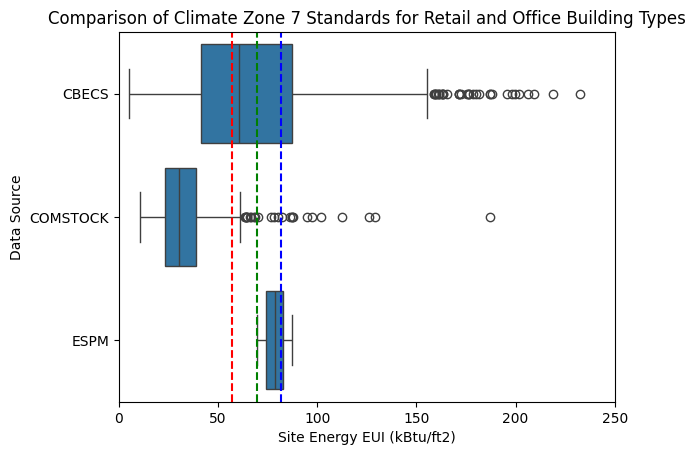

In [16]:
# CBECS Data Handling: 
#   Filter to retail and office building types
#       Note: Only included "2 - Office" and "25 - Retail other than mall"; did not include "23 - Strip shopping center" or "24 - Enclosed mall"
#   calculate the total kbtu/ft2 for each building
#   add in literal column for data_source for union
#   Filter just to climate zone "Cold or Very Cold" (See lookups.py in the cbecs data folder for additional definitions for different numbers, not the same as climate zone numbers)
#   Select data needed for union and visualization
cbecs2018_OfficeAndRetail = cbecs2018[cbecs2018['PBA'].isin([2, 25])]
cbecs2018_OfficeAndRetail["EUI _kBTUft2"] = cbecs2018_OfficeAndRetail["MFBTU"] / cbecs2018_OfficeAndRetail["SQFT"]
cbecs2018_OfficeAndRetail["data_source"] = "CBECS"
cbecs2018_OfficeAndRetail["PUBCLIM"] = 1
cbecs2018_OfficeAndRetailForComparison = cbecs2018_OfficeAndRetail[["data_source","EUI _kBTUft2"]]

# Comstock Data Handling:
#   Filter to retail and office building types
#       Note: did not include RetailStripMall
#   Filter just to climate zone 7 (very cold)
#   add in literal column for data_source for union and display in visualization
#   Select data needed for union and visualization
#   Rename columns for union
comstock_OfficeAndRetail = df_all[df_all['in.comstock_building_type'].isin(["LargeOffice","SmallOffice","RetailStandalone","MediumOffice"])] 
comstock_OfficeAndRetail_cz7 = comstock_OfficeAndRetail[comstock_OfficeAndRetail['in.ashrae_iecc_climate_zone_2006'].str.contains('7')]
comstock_OfficeAndRetail_cz7["data_source"] = "COMSTOCK"
comstock_OfficeAndRetail_cz7ForComparison = comstock_OfficeAndRetail_cz7[["data_source","out.site_energy.total.energy_consumption_intensity"]]
comstock_OfficeAndRetail_cz7ForComparison = comstock_OfficeAndRetail_cz7ForComparison.rename(columns={"out.site_energy.total.energy_consumption_intensity": "EUI _kBTUft2"})

# ESPM Data Handling
#   Filter to retail and office building types
#       Note: did not include "Mailing Center/Post Office", "Medical Office", or "Veterinary Office"
#   add in literal column for data_source for union and display in visualization
#   Filter just to climate zone 7 (very cold)
#   Select data needed for union and visualization
#   Rename columns for union
espm_data_OfficeAndRetail = espm_data[espm_data['PropertyTypeSubcategory'].isin(["Other - Retail/Mall","Retail Store","Financial Office","Office"])] 
espm_data_OfficeAndRetail["data_source"] = "ESPM"
espm_data_OfficeAndRetail = espm_data_OfficeAndRetail[espm_data_OfficeAndRetail['ClimateZone'].str.contains('7')]
espm_data_OfficeAndRetail = espm_data_OfficeAndRetail[["data_source","Median"]]
espm_data_OfficeAndRetailForComparison = espm_data_OfficeAndRetail.rename(columns={"Median": "EUI _kBTUft2"})

# Union data_sources for visualization
union_df = pd.concat([cbecs2018_OfficeAndRetailForComparison, comstock_OfficeAndRetail_cz7ForComparison, espm_data_OfficeAndRetailForComparison], ignore_index = True)

#Create box plot
sns.boxplot(data=union_df, x="EUI _kBTUft2", y="data_source")

# Create percentile lines, averaged for all building types in zone 7
# Filter to retail and office building types
#   Note: Did not include "Medical office (nondiagnostic)", "Medical office (diagnostic)","Post office/postal center", "Courthouse/probation office","Enclosed mall", or "Strip shopping mall"
std100_25thPercentile_OfficeAndRetail = std100_25thPercentile[std100_25thPercentile["Commercial Building Type"].isin(["Other retail","Retail store","Admin/professional office","Government office","Mixed-use office","Other office"])]
std100_25thPercentile_mean_OfficeAndRetail = std100_25thPercentile_OfficeAndRetail[7].mean()

std100_40thPercentile_OfficeAndRetail = std100_40thPercentile[std100_40thPercentile["Commercial Building Type"].isin(["Other retail","Retail store","Admin/professional office","Government office","Mixed-use office","Other office"])]
std100_40thPercentile_mean_OfficeAndRetail = std100_40thPercentile_OfficeAndRetail[7].mean()

std100_50thPercentile_OfficeAndRetail = std100_50thPercentile[std100_50thPercentile["Commercial Building Type"].isin(["Other retail","Retail store","Admin/professional office","Government office","Mixed-use office","Other office"])]
std100_50thPercentile_mean_OfficeAndRetail = std100_50thPercentile_OfficeAndRetail[7].mean()


plt.axvline(std100_25thPercentile_mean_OfficeAndRetail, color='r', linestyle='--')
plt.axvline(std100_40thPercentile_mean_OfficeAndRetail, color='g', linestyle='--')
plt.axvline(std100_50thPercentile_mean_OfficeAndRetail, color='b', linestyle='--')
plt.xlabel('Site Energy EUI (kBtu/ft2)')
plt.ylabel('Data Source')
plt.title(f'Comparison of Climate Zone 7 Standards for Retail and Office Building Types')
plt.xlim(0,250)
